In [1]:
import numpy as np
import faiss

## Helper Functions

In [2]:
def semi_optimized_exhaustive_search(
        index_vectors: np.ndarray,
        query_vectors: np.ndarray,
        k: int,
):
    """
    This function performs an optimized exhaustive search.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        dim: The dimensionality of the vectors.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k nearest neighbors for each query vector.
    """
    ann_lists = []
    for query_vec in query_vectors:
        distances = np.linalg.norm(index_vectors - query_vec, axis=1)
        ann_lists.append(list(np.argsort(distances)[:k]))
    return np.array(ann_lists)

In [3]:
def build_faiss_flatl2_index(
        index_vectors: np.ndarray,
        dim: int,
):
    """
    This function builds a Faiss flat L2 index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
    Returns:
        A Faiss flat L2 index.
    """
    index = faiss.IndexFlatL2(dim)
    index.add(index_vectors)
    return index

In [4]:
def faiss_search(
        query_vectors: np.ndarray,
        index: faiss.Index,
        k: int,
):
    """
    This function uses a Faiss index to search for the k-nearest neighbors of query_vectors.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        index: A Faiss index.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (, ) containing the indices of the k-nearest neighbors for each query vector.
    """
    distances, indices = index.search(query_vectors, k)
    return indices

In [5]:
def build_faiss_lsh_index(
        index_vectors: np.ndarray,
        dim: int,
        nbits: int,
):
    """
    This function builds a Faiss LSH index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
        nbits: The number of bits to use in the hash.
    Returns:
        A Faiss LSH index.
    """
    index = faiss.IndexLSH(dim, nbits)
    index.add(index_vectors)
    return index

In [6]:
def compute_recall_at_k(
        nn_gt: np.ndarray,
        ann: np.ndarray,
        k: int,
):
    """
    This function computes the recall@k.
    Args:
        nn_gt: The ground truth nearest neighbors.
        ann: The approximate nearest neighbors.
        k: The number of nearest neighbors to consider.
    Returns:
        The recall@k.
    """
    return round(sum([len(set(ann[i]) & set(nn_gt[i])) / k for i in range(len(ann))])/len(ann), 3)

# 2.1 -- LSH vs Naive Exhaustive Search (Regular Index Vectors)
### You just have to run the following cells:
* running time of the ground truth computation with semi_optimized_exhaustive_search (wall time)
* running time of creating faiss_lsh_index (wall time)
* running time of faiss_search over query_vectors with faiss_lsh_index (wall time)
* recall@10 for faiss_lsh_ann

In [7]:
query_vectors = np.load('data/query_vectors.npy')
index_vectors = np.load('data/index_vectors.npy')
k = 10
dim = index_vectors.shape[1]

In [8]:
%%time
gt_nn = semi_optimized_exhaustive_search(index_vectors, query_vectors, k)

CPU times: user 12.1 s, sys: 56.5 ms, total: 12.1 s
Wall time: 12.1 s


In [9]:
%%time
faiss_lsh_index = build_faiss_lsh_index(index_vectors, dim, nbits=2000)

CPU times: user 1.55 s, sys: 160 ms, total: 1.71 s
Wall time: 872 ms


In [10]:
%%time
faiss_lsh_ann = faiss_search(query_vectors, faiss_lsh_index, k)

CPU times: user 5.29 s, sys: 11.6 ms, total: 5.3 s
Wall time: 2.65 s


In [11]:
print(f"recall@10 for faiss_lsh_index: {compute_recall_at_k(gt_nn, faiss_lsh_ann, k)}")

recall@10 for faiss_lsh_index: 0.11


# 2.2 -- Custom Indexing Algorithm
Build an indexing algorithm that satisfies the following requirements:
* The indexing algorithm should be able to handle vectors of different dimensions
* The running time of the indexing should be less than half of the running time of semi_optimized_exhaustive_search), reported in Section 2.1.
* The running time of searching over the index should be less than a third (1/3) of the time of the semi_optimized_exhaustive_search function, reported in Section 2.1.
* The performance (in terms of recall@10) of the indexing algorithm should be at least 0.25.

You are allowed to add as many helper functions as you need, as long as all of them appear in the next cell (the one containing custom_indexing_algorithm and custom_index_search). You cannot use faiss or scipy libraries for this task. Numpy is allowed. 

You can also test your algorithm with the additional two query-index sets by replacing the calls made few cells ago to:


In [67]:
#TODO: Write your code for 2.2.2 here
# You are allowed to add more arguments to the functions and create more functions if needed.

from collections import defaultdict

def initialize_random_centroids(K, X):
    """Initializes and returns k random centroids"""
    m, n = np.shape(X)
    centroids = np.empty((K, n))
    for i in range(K):
        # pick a random data point from X as the centroid
        centroids[i] =  X[np.random.choice(range(m))] 
    return centroids

def closest_centroid(x, centroids, K):
    """Finds and returns the index of the closest centroid for a given vector x"""
    distances = np.empty(K)
    for i in range(K):
        # compute distance from each centroid to a data point
        distances[i] = np.linalg.norm(centroids[i] - x)
    return np.argmin(distances) # return the index of the closest centroid

def assign_clusters(centroids, K, X):
    """Returns an array of cluster indices for all the data samples"""
    m, _ = np.shape(X)
    cluster_idx = np.empty(m)
    for i in range(m):
        cluster_idx[i] = closest_centroid(X[i], centroids, K)
    return cluster_idx

def compute_means(cluster_idx, K, X):
    """Computes and returns the new centroids of the clusters"""
    _, n = np.shape(X)
    centroids = np.empty((K, n))
    for i in range(K):
        points = X[cluster_idx == i]
        if len(points) == 0:
            centroids[i] = X[np.random.choice(len(X))]  # reinit
        else:
            centroids[i] = np.mean(points, axis=0)
    return centroids
    

def run_k_means(K, X, max_iterations=100):
    """Runs the k-means algorithm and computes the final clusters"""
    centroids = initialize_random_centroids(K, X)  # initialize random centroids
    for i in range(max_iterations):
        clusters = assign_clusters(centroids, K, X)  # assign data points to centroids
        previous_centroids = centroids.copy()                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
        centroids = compute_means(clusters, K, X)
        diff = previous_centroids - centroids
        if np.abs(diff).max() < 0.01:  # if there was no change - stop
            break
    return centroids, clusters


def custom_indexing_algorithm(index_vectors, dim, n_clusters):
    centroids, clusters = run_k_means(n_clusters, index_vectors)
    
    # build mapping from cluster_id to vectors
    inverted_lists = defaultdict(list)
    for i, cluster_id in enumerate(clusters.astype(int)):
        inverted_lists[cluster_id].append((index_vectors[i], i))  # store tuple: (vector, original index)
    
    for cluster_id in inverted_lists:
        vectors, indices = zip(*inverted_lists[cluster_id])
        inverted_lists[cluster_id] = (np.vstack(vectors), np.array(indices))
        
    return centroids, inverted_lists


def custom_index_search(query_vectors, index, k):
    centroids, inverted_lists = index
    results = []
    
    for query_vec in query_vectors:
        cluster_idx = closest_centroid(query_vec, centroids, len(centroids))
        vectors, original_indices = inverted_lists[cluster_idx]

        distances = np.linalg.norm(vectors - query_vec, axis=1)
        nearest_indices = original_indices[np.argsort(distances)[:k]]
        results.append(list(nearest_indices))
    return np.array(results)
        
    

In [92]:
# Add hyperparameters here (if needed)
N_CLUSTERS = 6

In [93]:
%%time
custom_index = custom_indexing_algorithm(index_vectors, dim, N_CLUSTERS)

CPU times: user 1.96 s, sys: 72.9 ms, total: 2.03 s
Wall time: 1.95 s


In [94]:
%%time
custom_index_ann = custom_index_search(query_vectors, custom_index, k)

CPU times: user 5.02 s, sys: 0 ns, total: 5.02 s
Wall time: 5.02 s


In [95]:
print(f"recall@10 for custom_index_search: {compute_recall_at_k(gt_nn, custom_index_ann, k)}")

recall@10 for custom_index_search: 0.531


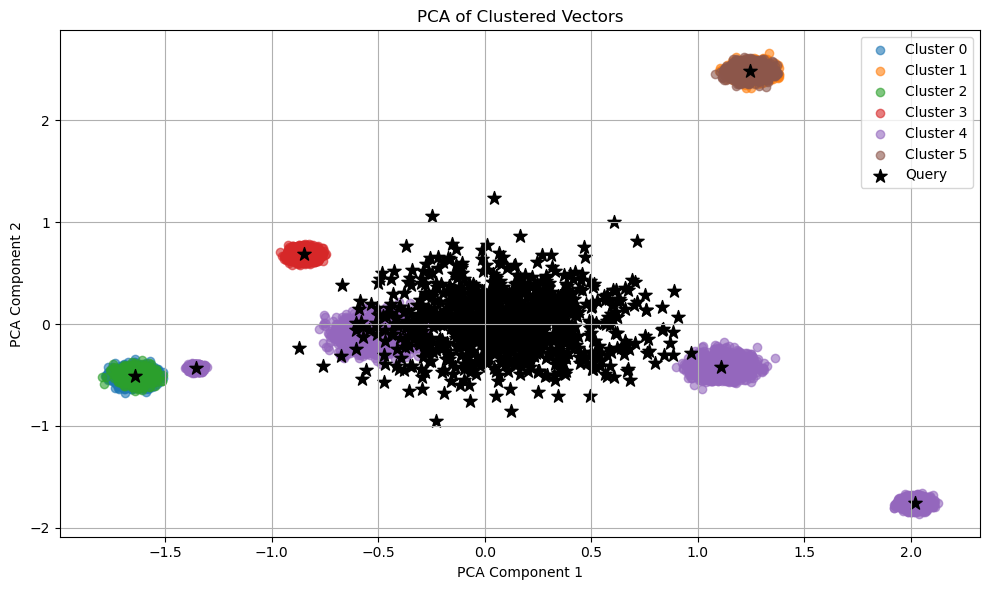

In [96]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_clusters_pca(inverted_lists, query_vectors=None):
    all_vectors = []
    all_labels = []

    for cluster_id, (vectors, _) in inverted_lists.items():  # unpack (vectors, indices)
        all_vectors.append(vectors)
        all_labels.extend([cluster_id] * len(vectors))

    all_vectors = np.vstack(all_vectors)
    all_labels = np.array(all_labels)

    # Apply PCA to reduce to 2D
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(all_vectors)

    # Plot clusters
    plt.figure(figsize=(10, 6))
    for cluster_id in np.unique(all_labels):
        cluster_points = reduced[all_labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}", alpha=0.6)

    # Plot query vectors (if given)
    if query_vectors is not None:
        query_pca = pca.transform(query_vectors)
        plt.scatter(query_pca[:, 0], query_pca[:, 1], marker="*", color="black", label="Query", s=100)

    plt.title("PCA of Clustered Vectors")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_clusters_pca(custom_index[1], query_vectors=query_vectors)